In [1]:
import tensorflow as tf
import numpy as np
import cv2

In [2]:
import glob
import os

In [3]:
def loadImages(trainPath, imageSize, classes = ["dogs", "cats"]):
    """Load images the path to the folder that contains
    the images. Return images, its labels and the name of images.
    
    trainPath: path to folder that contains images to train
    imageSize: the size used in cv2.resize()
    classes: types of images to train for
    """
    images = []
    labels = []
    imageNames = []

    for className in classes:   
        index = classes.index(className)
        path = os.path.join(trainPath, className, '*g')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (imageSize, imageSize),0,0, cv2.INTER_LINEAR)
            image = image.astype(np.float32)
            image = np.multiply(image, 1.0 / 255.0)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            imageNames.append(fl)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, imageNames

In [4]:
np.random.seed(1)
tf.set_random_seed(1)

In [5]:
trainPath = "train"
imageSize = 64
images, labels, imageNames = loadImages(trainPath, imageSize)

In [6]:
classes = ["dogs", "cats"]
numOfChannels = 3
session = tf.Session()
x = tf.placeholder(tf.float32, shape=[None, imageSize,imageSize,numOfChannels], name='x')
trueY = tf.placeholder(tf.float32, shape=[None, len(classes)], name='trueY')

In [7]:
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [8]:
def create_convolutional_layer(input, numOfChannels, sizeOfFilter, numOfFilters):
    """Returns a constructed convolutional layer.
    
    numOfChannels: number of channels. For RGB it's 3.
    sizeOfFilter: size of filter used in convolutional layer.
    numOfFilters: number of filters (feature maps used in the convolutional lyaer)
    """
    # randomly initialize weights and bias to train for this layer
    weights = create_weights(shape=[sizeOfFilter, sizeOfFilter, numOfChannels, numOfFilters])
    biases = create_biases(numOfFilters)
    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

    layer += biases
    # max-pooling.  
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
    # activating with relu
    layer = tf.nn.relu(layer)

    return layer

In [9]:
def create_flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features])
    return layer

In [10]:
def create_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [11]:
filterSize = 3
# num of filters in convolution layer 1,2,3
numOfLayersConv1 = 16
numOfLayersConv2 = 16
numOfLayersConv3 = 32
# size of fully connected layer
sizeOfFCLayer = 64

In [12]:
layer_conv1 = create_convolutional_layer(x,
               numOfChannels,
               filterSize,
               numOfLayersConv1)
layer_conv2 = create_convolutional_layer(layer_conv1,
               numOfLayersConv1,
               filterSize,
               numOfLayersConv2)

layer_conv3= create_convolutional_layer(layer_conv2,
               numOfLayersConv2,
               filterSize,
               numOfLayersConv3)

In [13]:
layer_flat = create_flatten_layer(layer_conv3)

In [14]:
layer_fc1 = create_fc_layer(input=layer_flat,
                     num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                     num_outputs=sizeOfFCLayer,
                     use_relu=True)

In [15]:
layer_fc2 = create_fc_layer(input=layer_fc1,
                     num_inputs=sizeOfFCLayer,
                     num_outputs=len(classes),
                     use_relu=False) 

In [16]:
y_pred = tf.nn.softmax(layer_fc2,name='y_pred')
session.run(tf.global_variables_initializer())
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                    labels=trueY)

In [17]:
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [18]:
session.run(tf.global_variables_initializer()) 

In [19]:
import time

saver = tf.train.Saver()
def train(num_iteration):
    runtimes = np.zeros((num_iteration, 4))
    
    for i in range(num_iteration):

        for j in range(4):   
            feed_dict_tr = {x: images[j].reshape((1, 64, 64, 3)),
                               trueY: labels[j].reshape((1, 2))}
            st = time.time()
            session.run(optimizer, feed_dict=feed_dict_tr)
            runtimes[i, j] = time.time() - st
        
        saver.save(session, 'dogs-cats-model') 
    
    with open('runtime', 'w') as f:
        for i in range(runtimes.shape[0]):
            f.write("{}\n".format(runtimes[i]))

train(num_iteration=10)

In [20]:
testPath = "test"
imageSize = 64
images, labels, imageNames = loadImages(testPath, imageSize)

In [21]:
## Let us restore the saved model 
sess = tf.Session()
# Step-1: Recreate the network graph. At this step only graph is created.
saver = tf.train.import_meta_graph('dogs-cats-model.meta')
# Step-2: Now let's load the weights saved using the restore method.
saver.restore(sess, tf.train.latest_checkpoint('./'))

# Accessing the default graph which we have restored
graph = tf.get_default_graph()

# Now, let's get hold of the op that we can be processed to get the output.
# In the original network y_pred is the tensor that is the prediction of the network
y_pred = graph.get_tensor_by_name("y_pred:0")

INFO:tensorflow:Restoring parameters from ./dogs-cats-model


In [22]:
x= graph.get_tensor_by_name("x:0") 
y_true = graph.get_tensor_by_name("trueY:0") 


### Creating the feed_dict that is required to be fed to calculate y_pred 
feed_dict_testing = {x: images[0].reshape((1, 64, 64, 3)),
                               trueY: labels[0].reshape((1, 2))}
result=sess.run(y_pred, feed_dict=feed_dict_testing)
# result is of this format [probabiliy_of_rose probability_of_sunflower]
print(result)

[[ 0.65159941  0.34840059]]


In [23]:
print (labels[0])

[ 1.  0.]


In [24]:
imageNames[0]

'test/dogs/dog.3.jpg'

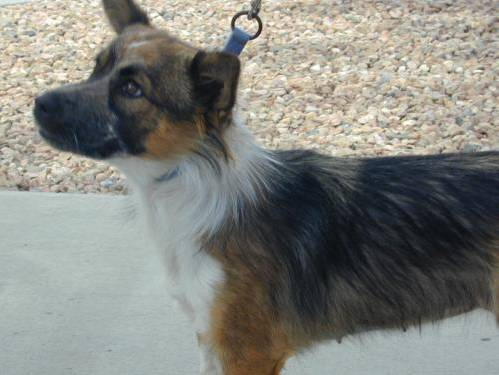

In [25]:
from IPython.display import Image
Image(filename='test/dogs/dog.3.jpg') 

In [26]:
import time

In [27]:
"dog" in imageNames[0]

True